[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cadCAD-org/demos/blob/master/tutorials/robots_and_marbles/robot-marbles-part-7/robot-marbles-part-7.ipynb)

# cadCAD Tutorials: The Robot and the Marbles, part 7
In parts [1](../robot-marbles-part-1/robot-marbles-part-1.ipynb) and [2](../robot-marbles-part-2/robot-marbles-part-2.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters
* Policies

In [part 3](../robot-marbles-part-3/robot-marbles-part-3.ipynb) we covered how to describe the presence of asynchronous subsystems within the system being modeled in cadCAD. And [part 4](../robot-marbles-part-4/robot-marbles-part-4.ipynb) introduced Monte Carlo simulations.

In [part 6](../robot-marbles-part-4/robot-marbles-part-6.ipynb) we conducted A/B tests using different system initial conditions to see the differences.

In this notebook, we'll cover cadCAD's support for parameters and parameter sweeping, a useful feature to produce multiple configurations with different parameters. As in Part 6, let's start by copying the base configuration with which we ended Part 4. Here's the description of that system:

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and __two__ robot arms capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robots are programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. They repeat that process until the boxes contain an equal number of marbles.
* The robots act __asynchronously__ and __non-deterministically__; at every timestep each robot acts with a probability P: 50% for robot 1 and 33.33% for robot 2.


We have added a new parameter in the `robot_arm` function called `capacity`. This is the amount of marbles a robot can move from one box to the other each time.

In [1]:
%%capture
# Only run this cell if you need to install the libraries
# If running in google colab, this is needed.

!pip install cadcad matplotlib pandas numpy

In [2]:
# Import dependancies

# Data processing and plotting libraries
import pandas as pd
import numpy as np
from random import random as rand
import matplotlib.pyplot as plt
from pprint import pprint

# cadCAD specific libraries
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor,ExecutionMode
from cadCAD import configs

In [3]:
def p_robot_arm(params, substep, state_history, previous_state, capacity=1):
    
    # Parameters & variables
    box_a = previous_state['box_A']
    box_b = previous_state['box_B']
    
    # Logic
    if box_b > box_a:
        b_to_a = capacity
    elif box_b < box_a:
        b_to_a = -capacity
    else:
        b_to_a = 0
    
    # Output
    return({'add_to_A': b_to_a, 'add_to_B': -b_to_a})

In [4]:
# We specify each of the robots logic in a Policy Function
robots_probabilities = [0.5,1/3] # Robot 1 acts with a 50% probability; Robot 2, 33.33%

def robot_arm_1(params, substep, state_history, previous_state):
    _robotId = 1
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return p_robot_arm(params, substep, state_history, previous_state)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) 

def robot_arm_2(params, substep, state_history, previous_state):
    _robotId = 2
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return p_robot_arm(params, substep, state_history, previous_state)
    else:
        return({'add_to_A': 0, 'add_to_B': 0})

In [5]:
def s_box_A(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_A_current = previous_state['box_A']
    box_A_change = policy_input['add_to_A']
   
    # Logic
    box_A_new = box_A_current + box_A_change
    
    # Output
    return ('box_A', box_A_new)
    
def s_box_B(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_B_current = previous_state['box_B']
    box_B_change = policy_input['add_to_B']

    # Logic
    box_B_new = box_B_current + box_B_change
    
    # Output
    return ('box_B', box_B_new)

In [6]:
partial_state_update_blocks = [
    { 
        'policies': { 
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': s_box_A,
            'box_B': s_box_B
        }
    }
]

In [7]:
initial_state = {
    'box_A': 10, # box_A starts out with 10 marbles in it
    'box_B': 0 # box_B starts out empty
}

In [8]:
del configs[:]

MONTE_CARLO_RUNS = 30
SIMULATION_TIMESTEPS = 10

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        #'M': {} # This will be explained in later tutorials
    }
)

In [9]:

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=experiment.configs)

(system_events, tensor_field, sessions) = run.execute()
df = pd.DataFrame(system_events)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 10, 0, 30, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (10, 0, 30, 2)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 1.53s


In [10]:
df.set_index(['simulation', 'run', 'timestep', 'substep'])

box_A  box_B  subset
simulation run timestep substep                      
0          1   0        0           10      0       0
               1        1           10      0       0
               2        1            9      1       0
               3        1            8      2       0
               4        1            8      2       0
...                                ...    ...     ...
           30  6        1            8      2       0
               7        1            8      2       0
               8        1            6      4       0
               9        1            6      4       0
               10       1            5      5       0

[330 rows x 3 columns]

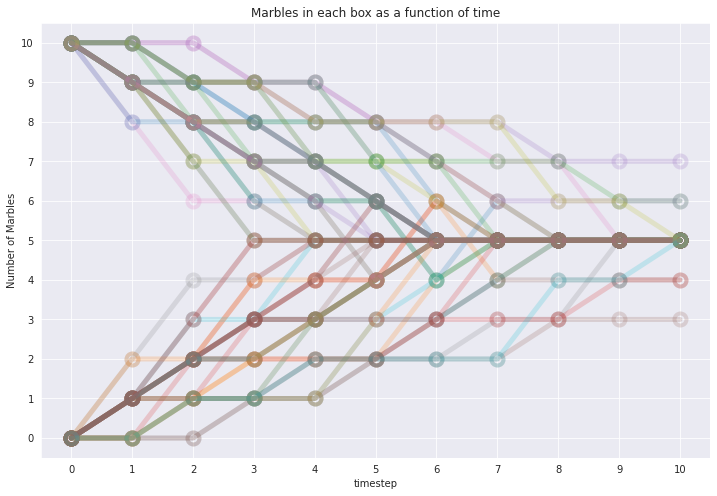

In [11]:
ax = None
for i in range(0,MONTE_CARLO_RUNS):
    ax =  df[df['run']==i+1].plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.2, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()), legend=None,
                yticks=list(range(1+(df['box_A']+df['box_B']).max())), ax=ax);

## Parameters
What would happen if we "upgrade" the capacity of one of our robot arm to being able to move two marbles at once?

In order to test that, let's first redefine robot arms policies to get their capacity from the `params` parameter. That first `params` parameter is present in policy and state functions, and it makes reference to the dictionary of parameters of the system.

In [12]:
robots_probabilities = [0.5,1/3] # Robot 1 acts with a 50% probability; Robot 2, 33.33%

def robot_arm_1(params, substep, state_history, previous_state):
    _robotId = 1
    capacity = params['capacity'][f'robot_{_robotId}']
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return p_robot_arm(params, substep, state_history, previous_state, capacity)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) 

def robot_arm_2(params, substep, state_history, previous_state):
    _robotId = 2
    capacity = params['capacity'][f'robot_{_robotId}']
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return p_robot_arm(params, substep, state_history, previous_state, capacity)
    else:
        return({'add_to_A': 0, 'add_to_B': 0})
    
partial_state_update_blocks = [
    { 
        'policies': { 
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': s_box_A,
            'box_B': s_box_B
        }
    }
]

You may remember in previous tutorials we left the `M` key as an empty object and promised to use the parameters dictionary in further articles. This is the time. We set each arm's `capacity` here. Let's set the first robot arm capacity to 2 meanwhile we keep the second robot arm's capacity to 1.

Settings of general simulation parameters, unrelated to the system itself
* `T` is a range with the number of discrete units of time the simulation will run for;
* `N` is the number of times the simulation will be run (Monte Carlo runs)
* `M` is a dictionary of parameter keys 

In [13]:
del configs[:]
MONTE_CARLO_RUNS = 30
SIMULATION_TIMESTEPS = 10

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        'M': {
        'capacity': [
            {'robot_1': 2, 'robot_2': 1 }
            ]
        }
    }
)

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

When using params, we recommend to use the multi_proc execution mode. Let's see what is the effect of having an "upgraded" arm over the system.

In [14]:
exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=experiment.configs)

(system_events, tensor_field, sessions) = run.execute()
df = pd.DataFrame(system_events)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (2, 20, 1, 60, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (10, 0, 30, 2)
     Simulation 1: (Timesteps, Params, Runs, Sub-States) = (10, 1, 30, 2)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 3.33s


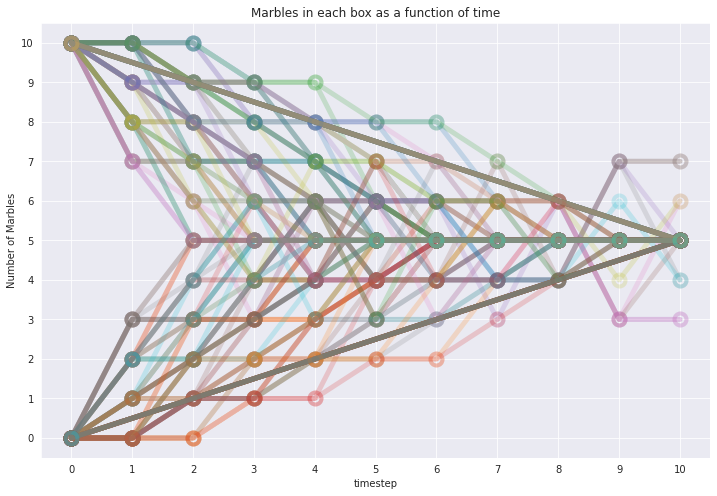

In [15]:
ax = None
for i in range(0,MONTE_CARLO_RUNS):
    ax =  df[df['run']==i+1].plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.2, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()), legend=None,
                yticks=list(range(1+(df['box_A']+df['box_B']).max())), ax=ax);

## Parameter sweeping
In order to simulate more than one versions of the same system, we can create many `Configuration` objects to pass to the `Executor` instead of just one. For example, suppose we wanted to test the system under three different arm capacitiy configurations.

Just like we did before, we package those initial conditions along with the partial state update blocks and the simulation parameters into `Configuration` objects. This time using the `append_configs` util for convenience. The configurations are stored in the `configs` list.

In [16]:
del configs[:]
MONTE_CARLO_RUNS = 30
SIMULATION_TIMESTEPS = 10

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        'M': {
            'capacity' : [
                    { 'robot_1': 1, 'robot_2': 1 }, # Each robot has capacity 1
                    { 'robot_1': 2, 'robot_2': 1 }, # Arm 1 has been "upgraded"
                    { 'robot_1': 2, 'robot_2': 2 }  # Both arms have been "upgraded"
            ]
        }
    }
)

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

And now we can execute the simulation of those three different versions of the system in parallel.

In [17]:
execution_mode = ExecutionMode()

exec_context = ExecutionContext(execution_mode.multi_mode)
run = Executor(exec_context=exec_context, configs=experiment.configs)

And we are ready to execute the simulation. The `execute()` method will return a list of tuples - the first element of those tuples correspond to the datapoints of each one of the versions of the system being simulated.

In [18]:
(system_events, tensor_field, sessions) = run.execute()
df = pd.DataFrame(system_events)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: multi_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (3, 30, 2, 150, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (10, 0, 30, 2)
     Simulation 1: (Timesteps, Params, Runs, Sub-States) = (10, 1, 30, 2)
     Simulation 2: (Timesteps, Params, Runs, Sub-States) = (10, 1, 90, 2)
Execution Method: parallelize_simulations
Execution Mode: parallelized
Total execution time: 7.73s


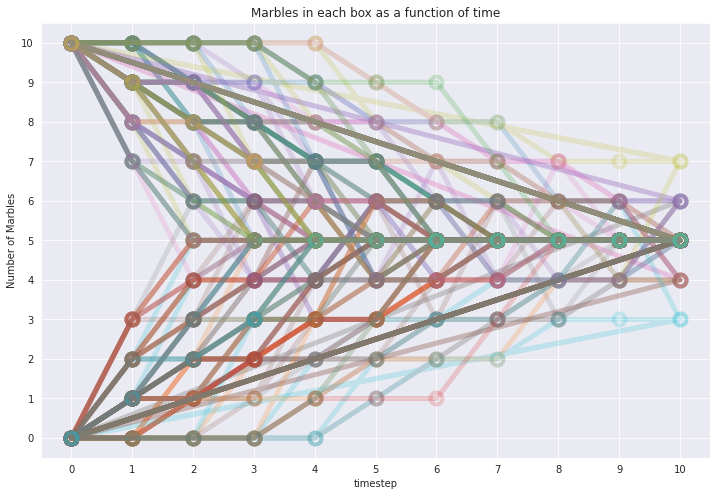

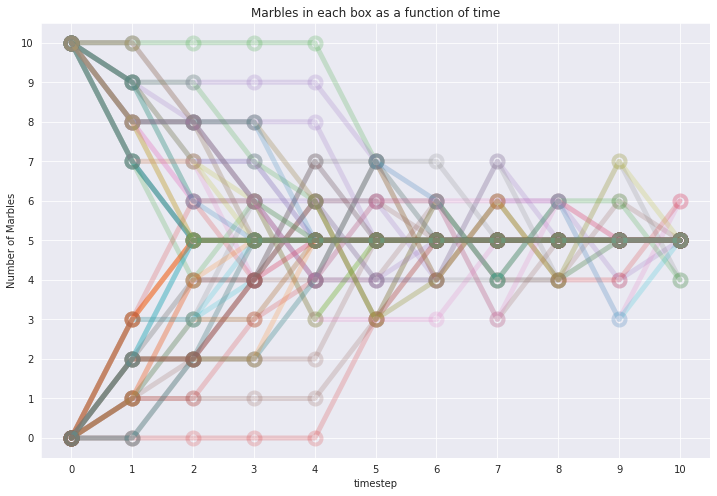

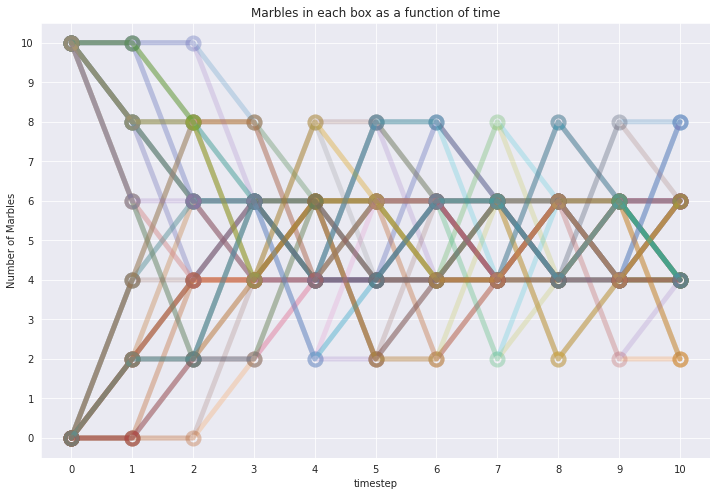

In [19]:
for subset in df.subset.unique():
    ax = None
    for i in range(0,MONTE_CARLO_RUNS):
        ax =  df[(df['subset']==subset) & (df['run']==i+1)].plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                    markeredgewidth=4, alpha=0.2, markerfacecolor='black',
                    linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                    ylabel='Number of Marbles', grid=True, fillstyle='none',  
                    xticks=list(df['timestep'].drop_duplicates()), legend=None,
                    yticks=list(range(1+(df[(df['subset']==subset)]['box_A']+df[(df['subset']==subset)]['box_B']).max())), ax=ax);

Can you see the differences between the graphs? You probably can see setting higher capacities in robot arms make the the marbles in the boxes converge faster but have a loosened variation, meanwhile lower capacities make them converge slower but tighter.

As stated, parameters can be used to parametrize the states and policies, and we can run parallel simulations testing different parameters generating different configurations with `config_sim`.